In [2]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
import skimage.io as io
import matplotlib.pyplot as plt

### Read Dataset

In [3]:
def read_images(folder_path):
   '''
    Read images from a folder and return them as a list of numpy arrays.
    Normalize the images
   '''
   images = []
   file_names = os.listdir(folder_path)
   for file_name in file_names:
         image = io.imread(os.path.join(folder_path, file_name))
         images.append(image)
   
   return images
 
# read dataset 
A = read_images('dataset/trainval/A') # initial images
B = read_images('dataset/trainval/B') # images after a certain amount of time
labels = read_images('dataset/trainval/label') # ground truth images (actual change)

assert len(A) == len(B) == len(labels), "Number of images in A, B and labels are not equal."

In [4]:
# Split dataset into training, validation and test sets
A_train, A_test, B_train, B_test, labels_train, labels_test = train_test_split(A, B, labels, test_size=0.3, random_state=42)

# we can use the same function to split the training set into training and validation sets
# A_train, A_val, B_train, B_val, labels_train, labels_val = train_test_split(A_train, B_train, labels_train, test_size=0.2, random_state=42)

## Research findings: <br>
1. I think the most appropriate approach given the dataset is ab Object-Based Chnage Detection (By adopting an object-based approach, you can achieve more accurate and meaningful results for change detection in complex landscapes such as desert areas, where pixel-based methods may be less effective due to spatial heterogeneity and spectral variability.) and since our dataset is detecting change in desert areas, specifically buildings.
2. For image prerpcessing: first step is to apply radiometric normalization to remove the atmospheric effect and any noise 


Random index:  21
Random image before change


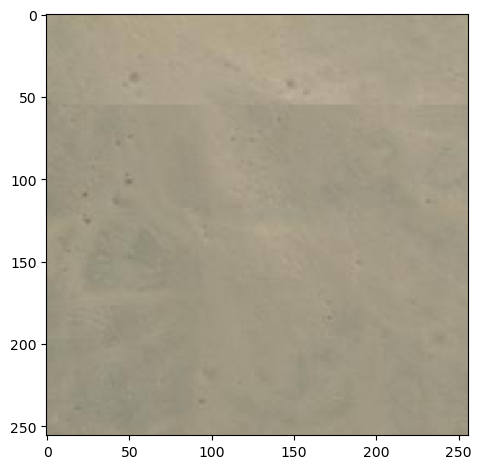

Random image after change


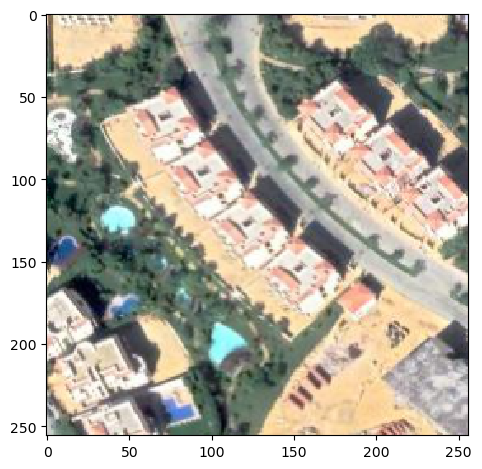

Change ground truth of the random image


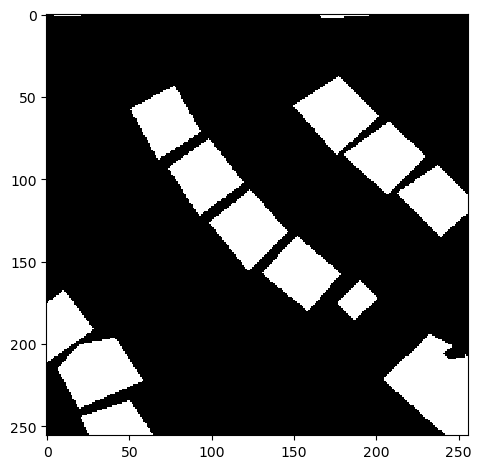

In [5]:
# 427 => white line

# Show first image in the training set
# np.random.seed(968652)
# random_index = np.random.randint(0, len(A_train))
random_index = 21
print("Random index: ", random_index)
print("Random image before change")
io.imshow(A_train[random_index])
io.show()

print("Random image after change")
io.imshow(B_train[random_index])
io.show()

print("Change ground truth of the random image")
io.imshow(labels_train[random_index])
io.show()

### Image Preprocessing


In [6]:
# For image preprocessing there are 3 main steps to try:
# 1. Radiometric correction
# 2. Geometric correction
# 3. Image enhancement
'''
There are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:
1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. 
2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. 
3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. 
4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.
'''

'\nThere are four main types of radiometric correction: radiometric calibration, atmospheric correction, topographic correction, and sensor normalization:\n1. Radiometric calibration converts the digital numbers (DN) of the image pixels to physical units, such as radiance or reflectance. \n2. Atmospheric correction removes or reduces the effects of atmospheric scattering, absorption, and haze on the image. \n3. Topographic correction adjusts the image for the variations in illumination and reflectance caused by the terrain relief. \n4. Sensor normalization harmonizes the images from different sensors or dates by eliminating the differences in radiometric characteristics.\n'

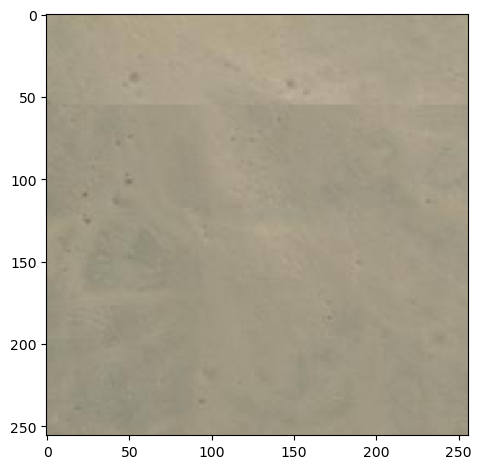

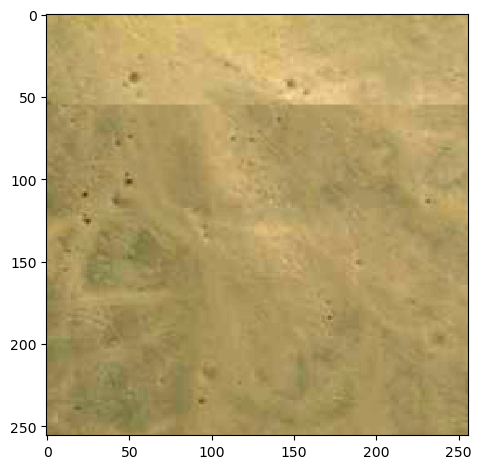

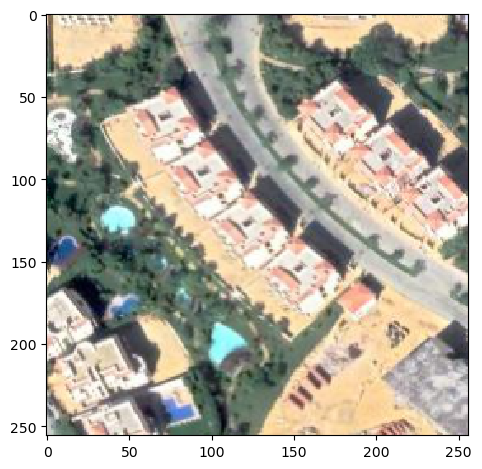

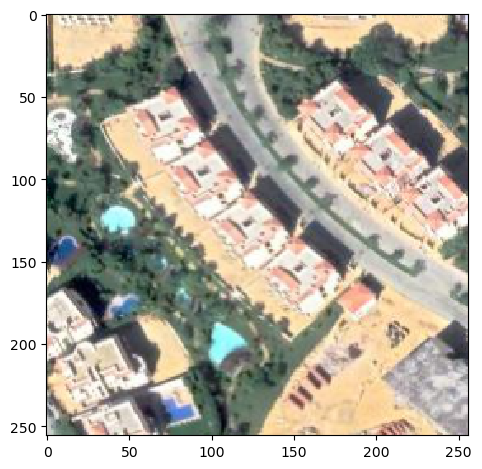

In [7]:
# Applying radiometric correction on a single image before and after

# Convert to floating point for radiometric correction
image_float_A = A_train[random_index].astype(np.float32)
image_float_B = B_train[random_index].astype(np.float32)

# Radiometric correction (e.g., flat field correction, atmospheric correction)
# Example: Subtract mean and divide by standard deviation
mean = np.mean(image_float_A)
std_dev = np.std(image_float_A)
corrected_image = (image_float_A - mean) / std_dev

# Normalize the corrected image to [0, 255]
normalized_image_A = cv2.normalize(corrected_image, None, 0, 255, cv2.NORM_MINMAX)
normalized_image_B = cv2.normalize(image_float_B, None, 0, 255, cv2.NORM_MINMAX)

# Convert back to uint8 format
normalized_image_A = np.uint8(normalized_image_A)
normalized_image_B = np.uint8(normalized_image_B)

# Display the original and normalized images
io.imshow(A_train[random_index])
io.show()
io.imshow(normalized_image_A)
io.show()

io.imshow(B_train[random_index])
io.show()
io.imshow(normalized_image_B)
io.show()

### Classical Technique:
#### Image Differencing

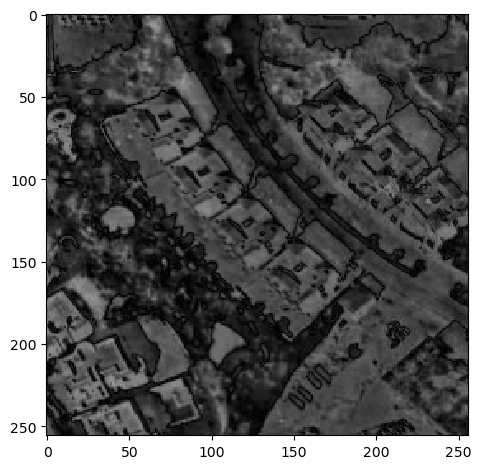

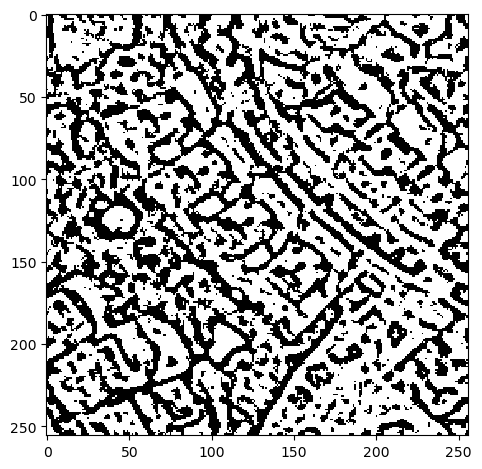

In [8]:
# Apply image differencing to detect changes

# convert to grayscale
gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)


# Compute the absolute difference between the two images
difference_image = cv2.absdiff(gray_image_A, gray_image_B)
# show the difference image
io.imshow(difference_image)
io.show()

blurred_image = cv2.medianBlur(difference_image,5)

# apply threshold to the difference image
# get the optimal threshold for the image
thresholded_image = cv2.adaptiveThreshold(blurred_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

thresholded_image = thresholded_image / 255.0

# show the difference image
io.imshow(thresholded_image)
io.show()

In [9]:
# convert images to grayscale
gray_image_A = cv2.cvtColor(normalized_image_A, cv2.COLOR_BGR2GRAY)
gray_image_B = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2GRAY)

# compute the mean and variance for A and B
mean_A = np.mean(gray_image_A)
mean_B = np.mean(gray_image_B)
var_A = np.var(gray_image_A)
var_B = np.var(gray_image_B)

# print the mean and variance for A and B
print("Mean of A: ", mean_A)
print("Mean of B: ", mean_B)
print("Variance of A: ", var_A)
print("Variance of B: ", var_B)


Mean of A:  140.08444213867188
Mean of B:  155.0019073486328
Variance of A:  239.67780604865402
Variance of B:  3385.6968805172946


In [10]:
# convert images to int
gray_image_A = gray_image_A.astype(np.int32)
gray_image_B = gray_image_B.astype(np.int32)

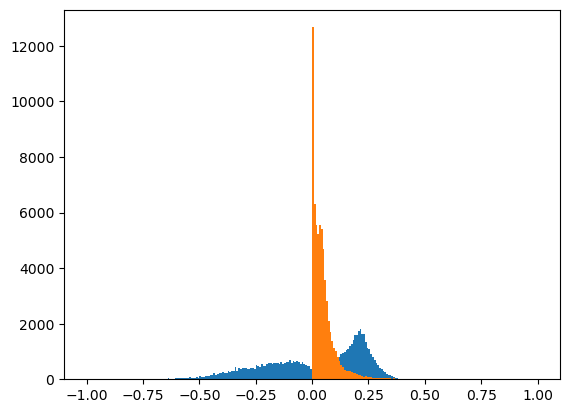

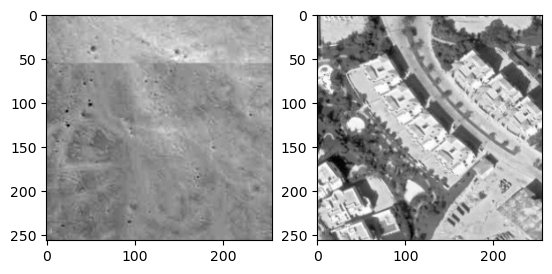

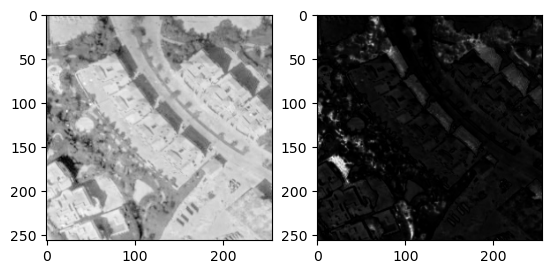

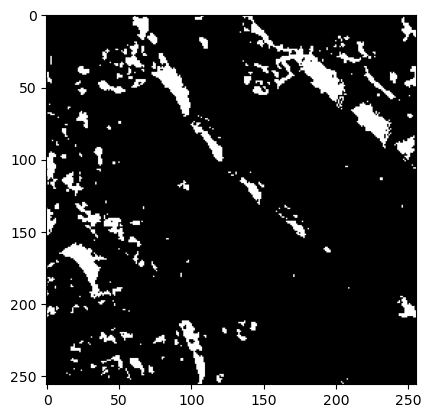

In [11]:
# Normalized Difference of time series and avoid zeros


ndvi = (gray_image_B - gray_image_A) / (gray_image_B + gray_image_A)
# plot histogram of image
plt.hist(ndvi.ravel(),256,[-1,1])

# square the image
squared_ndvi = np.square(ndvi)
plt.hist(squared_ndvi.ravel(),256,[-1,1])
plt.show()
# show ndvi and squared_ndvi side by side
plt.subplot(1,2,1)
plt.imshow(gray_image_A, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gray_image_B, cmap='gray')
plt.show()
plt.subplot(1,2,1)
plt.imshow(ndvi, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(squared_ndvi, cmap='gray')
plt.show()
# try different thresholds
threshold = 0.12
thresholded_image = np.where(squared_ndvi > threshold, 1, 0)
plt.imshow(thresholded_image, cmap='gray')
plt.show()


# # normalize



# # sqaure the image
# # NDVI = np.square(NDVI)

# NDVI = cv2.normalize(NDVI, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
# plt.imshow(NDVI, cmap='gray')
# plt.show()

# # histogram equalization
# NDVI = cv2.equalizeHist(NDVI)
# plt.imshow(NDVI, cmap='gray')
# plt.show()
# # # correct the image
# mean = np.mean(NDVI)
# std_dev = np.std(NDVI)
# NDVI = (NDVI - mean) / std_dev
# plt.imshow(NDVI, cmap='gray')

# thresholded_image = cv2.adaptiveThreshold(
#     NDVI.astype('uint8'), 255, cv2.THRESH_BINARY_INV, cv2.THRESH_BINARY, 11, 3)

# plt.imshow(thresholded_image, cmap='gray')
# plt.show()

# # normalize the image

# # adaptive thresholding

# thresholded_image = cv2.medianBlur(thresholded_image, 5)
# # invert the image
# # thresholded_image = cv2.bitwise_not(thresholded_image)

# # filter the image


# plt.imshow(thresholded_image, cmap="gray")

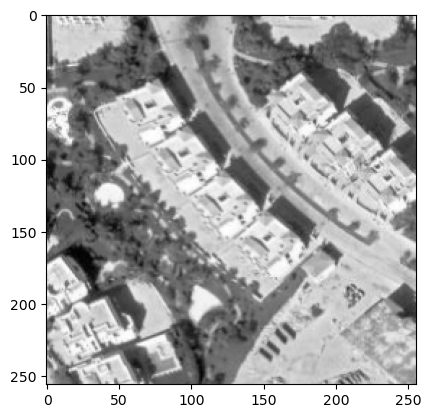

In [12]:
plt.imshow(gray_image_B, cmap="gray")

In [13]:
# perform image differencing on all images

# create an empty list to store the difference images
difference_images = []

# 1. data normalization
for a, b in zip(A, B):

    # standardize images
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    mean_a = np.mean(a)
    std_dev_a = np.std(a)
    mean_b = np.mean(b)
    std_dev_b = np.std(b)
    a = (a - mean_a) / std_dev_a
    b = (b - mean_b) / std_dev_b

    # normalize image
    a = cv2.normalize(a, None, 0, 255, cv2.NORM_MINMAX)
    b = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX)

    # convert to uint8 format
    a = np.uint8(a)
    b = np.uint8(b)

    # convert to grayscale
    gray_a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    gray_b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)

    # compute the absolute difference between the two images
    difference_image = cv2.absdiff(gray_a, gray_b)

    blurred_image = cv2.medianBlur(difference_image,5)
 

    # apply threshold to the difference image
    # get the optimal threshold for the image
    thresholded_image = cv2.adaptiveThreshold(blurred_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresholded_image = thresholded_image / 255.0

    difference_images.append(thresholded_image)



In [14]:
# # calculate the jaccard score for the difference images
# normalized_labels = [labels[i] / 255.0 for i in range(len(labels))]

# js = jaccard_score(normalized_labels, difference_images)

In [15]:
# normalized_image_A
# normalized_image_B

# lab_image = cv2.cvtColor(normalized_image_B, cv2.COLOR_BGR2LAB)
# # im1_b =  cv2.cvtColor(normalized_image_b, cv2.COLOR_BGR2LAB)


# # Split into the L, A, and B channels
# l, a, b = cv2.split(lab_image)

# # show channels
# plt.imshow(l, )
# plt.show()
# plt.imshow(a, )
# plt.show()
# plt.imshow(b, )
# plt.show()

# # Use a threshold to identify shadows; this value may need adjustment
# shadow_threshold = 100
# _, shadow_mask = cv2.threshold(l, shadow_threshold, 255, cv2.THRESH_BINARY_INV)

# # Optionally, use morphological operations to clean up the mask
# kernel = np.ones((3, 3), np.uint8)
# shadow_mask = cv2.dilate(shadow_mask, kernel, iterations=1)
# shadow_mask = cv2.erode(shadow_mask, kernel, iterations=2)

# # Increase brightness in shadow areas
# lighten_factor = 1.5  # This factor determines how much to lighten( the shadows
# l = cv2.add(l, (shadow_mask * lighten_factor).astype(np.uint8))

# updated_lab_image = cv2.merge([l, a, b])

# # Convert back to BGR color space
# result_image = cv2.cvtColor(updated_lab_image, cv2.COLOR_LAB2BGR)

# # display
# plt.imshow(result_image)
# plt.show()

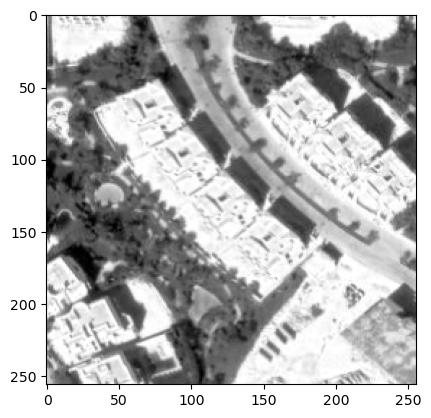

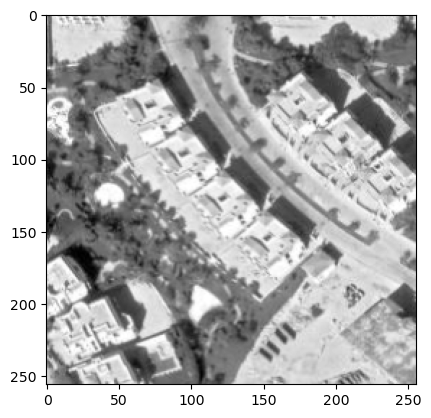

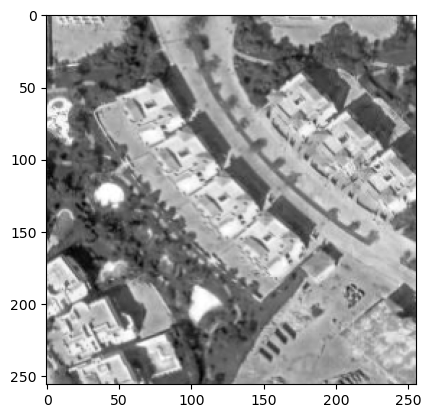

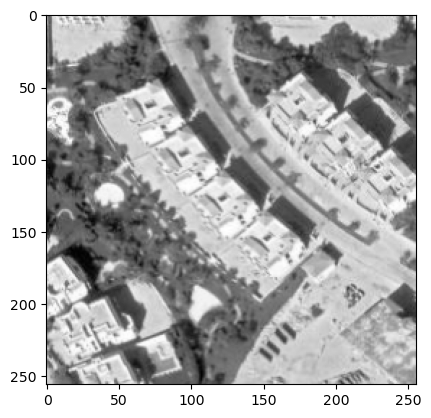

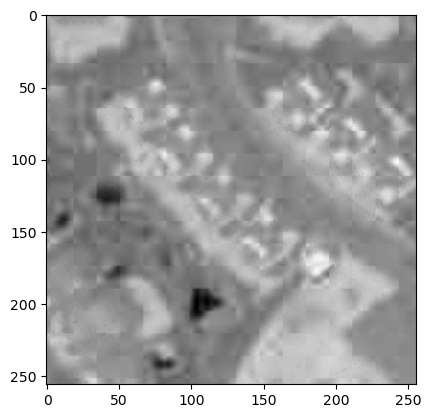

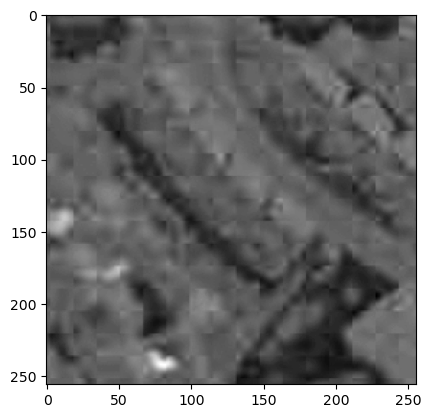

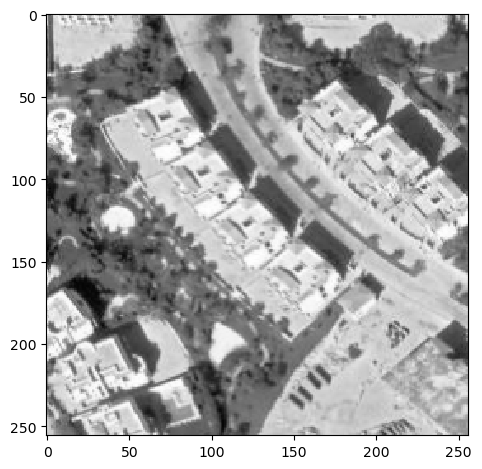

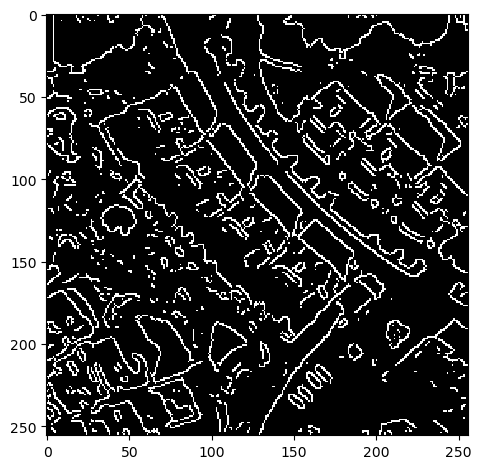

C:\Users\77\AppData\Local\Temp\ipykernel_43152\4057641923.py:29: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


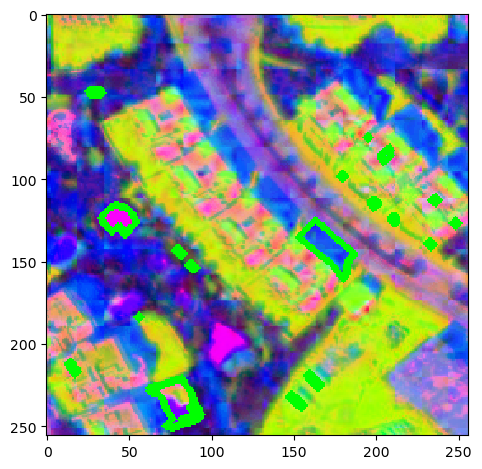

In [16]:
import cv2
import numpy as np

def is_rectangle(contour, epsilon=0.05, angle_threshold=30):
    # Approximate contour shape to a simpler polygon
    approx = cv2.approxPolyDP(contour, epsilon * cv2.arcLength(contour, True), True)
    
    # Rectangles and squares have 4 vertices
    if len(approx) != 4:
        return False

    # Check if the angles are close to 90 degrees
    cosines = []
    for i in range(4):
        j = (i + 1) % 4
        k = (i + 2) % 4
        p1, p2, p3 = approx[i][0], approx[j][0], approx[k][0]
        angle = np.abs(angle_between(p1, p2, p3))
        if np.abs(angle - 90) > angle_threshold:
            return False
    
    return True

def angle_between(p1, p2, p3):
    # Calculate angle between three points
    v1 = p2 - p1
    v2 = p3 - p2
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Load image, convert to grayscale and apply Gaussian blur
image = B_train[random_index]

# draw three channels
for i in range(3):
    
    plt.imshow(image[:, :, i], cmap='gray')
    plt.show()

image = cv2.cvtColor(B_train[random_index], cv2.COLOR_BGR2YUV)

# draw three channels
for i in range(3):
    plt.imshow(image[:, :, i], cmap='gray')
    plt.show()
# equalize each chanel
for i in range(3):
    image[:, :, i] = cv2.equalizeHist(image[:, :, i])

gray = cv2.cvtColor(B_train[random_index], cv2.COLOR_BGR2GRAY)
# histogram equalization

io.imshow(gray)
io.show()

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edges = cv2.Canny(blurred, 150, 150)

# show images
io.imshow(edges)
io.show()

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Image for drawing the detected rectangles
output = image.copy()

# Check each contour
for contour in contours:
    if is_rectangle(contour):
        # Draw the contour
        cv2.drawContours(output, [contour], -1, (0, 255, 0), 3)

# Show the result
io.imshow(output)


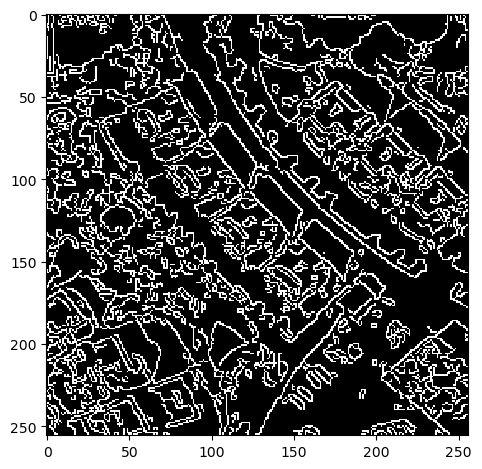

C:\Users\77\AppData\Local\Temp\ipykernel_43152\1420462626.py:28: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


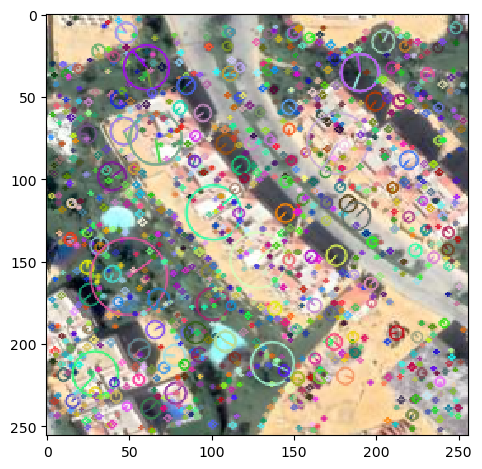

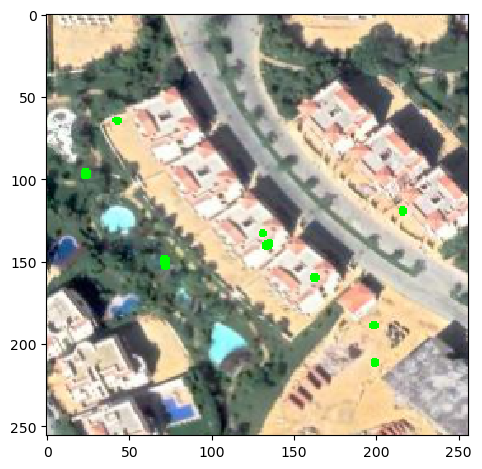

In [18]:
import cv2
import numpy as np

def is_rectangle(contour, epsilon=0.05, angle_threshold=30):
    # Approximate contour shape to a simpler polygon
    approx = cv2.approxPolyDP(contour, epsilon * cv2.arcLength(contour, True), True)
    
    # Rectangles and squares have 4 vertices
    if len(approx) != 4:
        return False

    # Check if the angles are close to 90 degrees
    for i in range(4):
        j = (i + 1) % 4
        k = (i + 2) % 4
        p1, p2, p3 = approx[i][0], approx[j][0], approx[k][0]
        angle = angle_between(p1, p2, p3)
        if np.abs(angle - 90) > angle_threshold:
            return False
    
    return True

def angle_between(p1, p2, p3):
    # Calculate angle between three points
    v1 = p2 - p1
    v2 = p3 - p2
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Load image

image = B_train[random_index]
gray = cv2.cvtColor(B_train[random_index], cv2.COLOR_BGR2GRAY)
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw keypoints
keypoint_img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Detect edges for contour analysis
edges = cv2.Canny(gray, 100, 200)
io.imshow(edges)
io.show()
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Image to draw rectangles
output = image.copy()

# Check each contour
for contour in contours:
    if is_rectangle(contour):
        cv2.drawContours(output, [contour], -1, (0, 255, 0), 2)

# Display results
# cv2.imshow('Keypoints', keypoint_img)
# cv2.imshow('Detected Rectangles', output)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
io.imshow(keypoint_img)
io.show()
io.imshow(output)
io.show()